# Tracking results analysis with MAD

This notebook is the last to be executed in order to analyse the data from the tracking if the results obtained in the Notebook "Data Analysis" were not satisfying.
The Median Absolute Deviation (MAD) method is a robust statistical technique used to identify outliers in a dataset. It is particularly effective because it is less sensitive to extreme values compared to the standard deviation. 

Since we did not previously verify the tracking of each label by overlaying the segmentation on the raw image, we decided to identify the labels that have aberrant values and remove them from the calculations of the averages for each metric with the MAD.

We tested this method on a sample containing all the labels for the calculation of the average relative distances and speeds in the atrium and ventricle. Then, we tested it on two samples by separating the labels into two groups: atrium and ventricle, for the calculations of the average volumes, solidities and sphericities in the atrium and ventricle over time.

This method did not show significant differences compared with the notebook "Data Analysis", regardless of the distributions performed, but the notebook remains accessible as open source if needed (it might show improvements with other examples in the future).

**Use the environment "myenv" for this notebook"**

To do this, import the myenv.yml file into your Home directory. Open it and change the prefix /rds/general/user/ecd24/home/anaconda3/envs/myenv to your own (usually, you just need to change ecd24 to your username). Open a terminal and execute the command 'conda env create -f myenv.yml'.

In this example, the zebrafish heart was captured by a light sheet fluorescent microscope with a frequency of 150 im/sec on 201 slices. This microscope stopped at each slice and captured 1 second of images. The z-movies have been imported in my home directory can be found in the folder called 'Z-slices'.

## The basic procedures : 

A - Relative distances over time

B - Speed over time 

C - Volume over time

D - Solidity over time (V/Vconv) 

E - Sphericity over time

**Note: Sometimes, the error `TypeError: unsupported operand type(s) for /: 'float' and 'NoneType'` appears for a reason I cannot explain. In that case, you have no choice but to restart the kernel and rerun the programs**

**If the error message `IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed` appears when running a program, rerun the cell with the initializations and then rerun the program.**

# Import Packages

In [1]:
import imageio as io 
from skimage.measure import label
from scipy.spatial import KDTree
import numpy as np
import matplotlib.pyplot as plt
import plotly.io as pio
import plotly.graph_objects as go
import random
import os
from scipy.signal import savgol_filter
from scipy.stats import shapiro, anderson, kstest, norm
import pandas as pd
from skimage.measure import regionprops
import time

# Initialisations

Note, the first dimension of the image should be the time (n°images), the second should be the number of slices, the third should be the height of each image, and the fourth should be the width. Verify the order with the cell below (in the given example, the dimensions are correct).

In [6]:
image = io.imread('labeled3D_with_time_image_LoG_ffn_worm3.ome.tif')
print(image.shape)

/var/tmp/pbs.9789540.pbs/ipykernel_150970/1938315741.py:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = io.imread('labeled3D_with_time_image_LoG_ffn_worm3.ome.tif')


(92, 201, 320, 300)


In [2]:
#real voxel size
voxel_size= (0.729, 0.729, 1.26) # x y and z sizes of the voxel in micron

#number of labels
image = io.imread('labeled3D_with_time_image_LoG_ffn_worm3.ome.tif')
image_1d = np.ravel(image)

# Count unique values
unique_values = np.unique(image_1d)
num_points = len(unique_values) - 1

delta = 1/(150)*1000

# Path to the directory containing the files
directory = 'worm1/track_results/coords_real/'
files = [f for f in os.listdir(directory) if f.startswith('coords') and f.endswith('.npy')]
num_files = len(files)

# Load all data at once
data = [np.load(os.path.join(directory, f'coords{j:06}.npy')) for j in range(num_files)]

# Another way to count the number of points
num_points = data[0].shape[0]
print(f"num_points:",num_points)

/var/tmp/pbs.9807721.pbs/ipykernel_3245069/418385078.py:5: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = io.imread('labeled3D_with_time_image_LoG_ffn_worm3.ome.tif')


num_points: 310


# Classes

In [3]:
# Classes :
Ventricle = [138,149,151,152,153,156,157,158,159,162,163,164,165,166,171,173,175,176,178,179,180,184,186,187,188,189,192,193,194,195,196,197,198,199,201,202,203,204,205,206,207,209,210,211,212,214,215,216,217,218,219,221,222,223,224,225,227,228,231,232,233,234,238,239,240,242,245,246,247,248,250,252,253,255,257,258,259,260,261,262,263,265,266,267,271,272,273,275,276,277,281,282,284,285,286,287,292,296]

Atrium = [15,20,23,24,25,26,27,29,30,31,32,36,37,39,40,42,43,45,46,47,49,50,51,52,55,57,58,59,61,62,63,68,70,71,72,73,74,75,77,78,79,80,81,82,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,102,104,105,106,107,108,111,112,113,115,118,119,120,122,123,124,125,126,127,128,130,132,134,135,136,137,139,140,142,143,144,146,147,148,160,167]

Sinus_Venosus = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,16,17,18,19,21,22,28,33,34,35,38,41,44,48,53,54,56,60,64,65,66,67,69,76,83,101,103,114,116,117,121,129,131,133,145,150,155,161,168,169,174,177,181,182,183,190,191,200,208,213,220,226,229,230,235,236,237,243,241,244,249,251,254,256,264,268,269,270,274,278,279,280,283,288,289,290,291,293,294,295,297,298,299,300,301,302,303,304,305,306,307,308,309,310]

Out = [109,110,141,154,172,170,185]

Not_identified_yet =  [i for i in range (1,num_points+1)  if i not in Atrium and i not in Ventricle and i not in Sinus_Venosus and i not in Out]

# A - Relative distances over time

The MAD method was performed on a sample containing all labels (and not on a sample containing all the nuclei of the atrium and then on another with all the nuclei of the ventricle).

Below is a program that displays a graph with all the labels that have been outliers with the number of times they were outliers, and a list of labels that were outliers more than **60 times** out of the 92 increments t.

In [4]:
outliers_all_time = []

all_labels_at_t_dict = {}
norm_velocity_dict = {}
list_outliers_at_t_dict = {}

def mad(data1):
    median = np.median(data1)
    mad_value = np.median(np.abs(data1 - median))
    return mad_value

def detect_outliers_mad(data1, threshold=2.5):
    median = np.median(data1)
    mad = np.median(np.abs(data1 - median))
    outliers = np.abs(data1 - median) > threshold * mad
    return outliers

def filter_outliers_by_frequency(outliers, freq, threshold=30):
    # Filter outliers with a frequency greater than the threshold
    filtered_outliers = outliers[freq > threshold]
    return filtered_outliers


relative_distance_3_closest_neighbours_dict = {}

# Create a KD tree with the generated points. The tree is a data structure
# used to organize points in a k-dimensional space.
# Query the tree to find the 3 nearest neighbors of the first point (data[label - 1]).
# The query method returns the distances and indices of the nearest neighbors.

for label in range(1, num_points + 1):
    relative_distance_3_closest_neighbours_dict[f'relative_distance_{label}'] =[]
    for j in range(num_files):  
        data = np.load(f'worm1/track_results/coords_real/coords{j:06}.npy')
        tree = KDTree(data)
        dist, ind = tree.query(data[label - 1], k=4) 
        ind = ind[ind != label-1]
        dist = dist[dist != 0]
        mean_with_3_closest_neighbours = (dist[0]+dist[1]+dist[2])/3
        relative_distance_3_closest_neighbours_dict[f'relative_distance_{label}'].append(mean_with_3_closest_neighbours)

for t in range(num_files-1):
    all_labels_at_t_dict[f't={t}']=[]
    list_outliers_at_t_dict[f't={t}']=[]
    for label in range(1, num_points + 1):
        all_labels_at_t_dict[f't={t}'].append(relative_distance_3_closest_neighbours_dict[f'relative_distance_{label}'][t])
    all_labels_at_t_dict[f't={t}'] = np.array(all_labels_at_t_dict[f't={t}'])
#     print("all_labels_at_t_dict[f't={t}']:", all_labels_at_t_dict[f't={t}'])
#     print(len(all_labels_at_t_dict[f't={t}']))
    # Calculate the MAD for this label
    mad_value = mad(all_labels_at_t_dict[f't={t}'])
#     print(f"MAD for this label : {mad_value:.2f}")
    # Detect outliers for this label
    outliers = detect_outliers_mad(all_labels_at_t_dict[f't={t}'])
    list_outliers_at_t_dict[f't={t}'] = np.where(outliers)[0]+1
    # Display detected outliers and their indices
    # print(f"Outliers at t={t}:", all_labels_at_t_dict[f't={t}'][outliers])
    # print(f"Indices of poorly tracked labels at t={t}:", list_outliers_at_t_dict[f't={t}'])
    outliers_all_time.extend(list_outliers_at_t_dict[f't={t}'])

# print(outliers_all_time)
    
outliers, freq = np.unique(outliers_all_time, return_counts=True)

# plt.plot(outliers, freq, marker='o', linestyle='-')
# plt.xlabel('outliers')
# plt.ylabel('frequency')
# plt.title('frequency of outliers')
# plt.grid(True)
# plt.show()

fig = go.Figure(data=go.Scatter(x=outliers, y=freq, mode='lines+markers'))
fig.update_layout(
    title='Frequency of Outliers',
    xaxis_title='Outliers',
    yaxis_title='Frequency',
    width=1200,  # Width of the figure
    height=800,  # Height of the figure
)
# Display the figure with the 'iframe' renderer
fig.show(renderer="iframe")


# Filter outliers with a frequency greater than 60
high_freq_outliers = filter_outliers_by_frequency(outliers, freq, threshold=60)

print("Outliers with frequency greater than 60:", high_freq_outliers)

# Remove common elements between Ventricle and high_freq_outliers from Ventricle
Ventricle_filtered = [item for item in Ventricle if item not in high_freq_outliers]

# Remove common elements between Atrium and high_freq_outliers from Atrium
Atrium_filtered = [item for item in Atrium if item not in high_freq_outliers]


Outliers with frequency greater than 60: [ 33  42  47  69  74 146 244 278 294 304]


- ## Average relative distances with standard deviation per class (atrium, ventricle) and cardiac phase (diastole, systole)

Unlike the same graph in the 'Data Analysis' notebook, this one was plotted by excluding from the average calculations the labels that were outliers more than **60 times**.

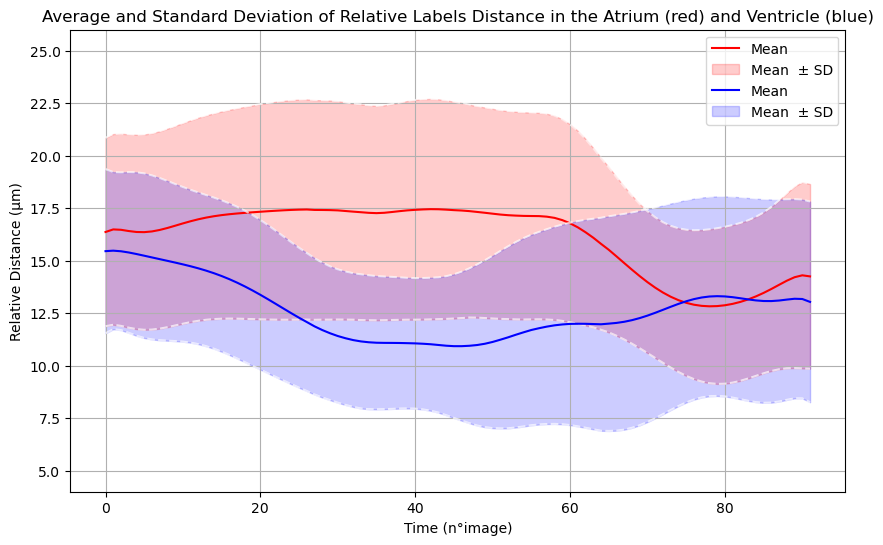

In [7]:
relative_distance_3_closest_neighbours_dict = {}

# Create a KD tree with the generated points. The tree is a data structure
# used to organize points in a k-dimensional space.
# Query the tree to find the 3 nearest neighbors of the first point (data[label - 1]).
# The query method returns the distances and indices of the nearest neighbors.

for label in range(1, num_points + 1):
    relative_distance_3_closest_neighbours_dict[f'relative_distance_{label}'] =[]
    for j in range(num_files):  
        data = np.load(f'worm1/track_results/coords_real/coords{j:06}.npy')
        tree = KDTree(data)
        dist, ind = tree.query(data[label - 1], k=4) 
        ind = ind[ind != label-1]
        dist = dist[dist != 0]
        mean_with_3_closest_neighbours = (dist[0]+dist[1]+dist[2])/3
        relative_distance_3_closest_neighbours_dict[f'relative_distance_{label}'].append(mean_with_3_closest_neighbours)

# ATRIUM 

mean_relative_distance_in_Atrium = np.mean([relative_distance_3_closest_neighbours_dict[f'relative_distance_{label}'] for label in Atrium_filtered], axis=0)
SD_relative_distance_in_Atrium = np.std([relative_distance_3_closest_neighbours_dict[f'relative_distance_{label}'] for label in Atrium_filtered], axis=0)

smoothing_mean_Atrium = savgol_filter(mean_relative_distance_in_Atrium,55,10)
smoothing_mean_plus_SD_Atrium = savgol_filter(mean_relative_distance_in_Atrium + SD_relative_distance_in_Atrium,55,10)
smoothing_mean_less_SD_Atrium = savgol_filter(mean_relative_distance_in_Atrium - SD_relative_distance_in_Atrium,55,10)


# Create the figure and axes
plt.figure(figsize=(10, 6))
plt.grid(True)

# Plot the mean
#plt.plot(mean_relative_distance_in_Atrium, label='Moyenne', color='blue')

plt.plot(smoothing_mean_Atrium, label='Mean', color='red')

# Plot the mean + SD
#plt.plot(mean_relative_distance_in_Atrium + SD_relative_distance_in_Atrium, linestyle='--', color='blue', alpha=0.7, label='Mean + SD')

plt.plot(smoothing_mean_plus_SD_Atrium, linestyle='--', color='white', alpha=0.7)

# Plot the mean - SD
#plt.plot(mean_relative_distance_in_Atrium - SD_relative_distance_in_Atrium, linestyle='--', color='blue', alpha=0.7, label='Mean - SD')

plt.plot(smoothing_mean_less_SD_Atrium, linestyle='--', color='white', alpha=0.7)

# Fill the area between mean + standard deviation and mean - standard deviation
#plt.fill_between(range(len(mean_relative_distance_in_Atrium)), mean_relative_distance_in_Atrium + SD_relative_distance_in_Atrium, mean_relative_distance_in_Atrium - SD_relative_distance_in_Atrium, color='blue', alpha=0.2)

plt.fill_between(range(len(mean_relative_distance_in_Atrium)), smoothing_mean_plus_SD_Atrium, smoothing_mean_less_SD_Atrium, color='red', alpha=0.2, label = 'Mean  ± SD')


# VENTRICLE

mean_relative_distance_in_Ventricle = np.mean([relative_distance_3_closest_neighbours_dict[f'relative_distance_{label}'] for label in Ventricle_filtered], axis=0)
SD_relative_distance_in_Ventricle = np.std([relative_distance_3_closest_neighbours_dict[f'relative_distance_{label}'] for label in Ventricle_filtered], axis=0)

smoothing_mean_Ventricle = savgol_filter(mean_relative_distance_in_Ventricle,55,10)
smoothing_mean_plus_SD_Ventricle = savgol_filter(mean_relative_distance_in_Ventricle + SD_relative_distance_in_Ventricle,55,10)
smoothing_mean_less_SD_Ventricle = savgol_filter(mean_relative_distance_in_Ventricle - SD_relative_distance_in_Ventricle,55,10)

# Plot the mean
#plt.plot(mean_relative_distance_in_Ventricle, label='Moyenne', color='blue')

plt.plot(smoothing_mean_Ventricle, label='Mean', color='blue')

# Plot the mean + SD
#plt.plot(mean_relative_distance_in_Ventricle + SD_relative_distance_in_Ventricle, linestyle='--', color='blue', alpha=0.7, label='Mean + SD')

plt.plot(smoothing_mean_plus_SD_Ventricle, linestyle='--', color='white', alpha=0.7)

# Plot the mean - SD
#plt.plot(mean_relative_distance_in_Ventricle - SD_relative_distance_in_Ventricle, linestyle='--', color='blue', alpha=0.7, label='Mean - SD')

plt.plot(smoothing_mean_less_SD_Ventricle, linestyle='--', color='white', alpha=0.7)

# Fill the area between mean + standard deviation and mean - standard deviation
#plt.fill_between(range(len(mean_relative_distance_in_Ventricle)), mean_relative_distance_in_Ventricle + SD_relative_distance_in_Atrium, mean_relative_distance_in_Ventricle - SD_relative_distance_in_Ventricle, color='blue', alpha=0.2)

plt.fill_between(range(len(mean_relative_distance_in_Ventricle)), smoothing_mean_plus_SD_Ventricle, smoothing_mean_less_SD_Ventricle, color='blue', alpha=0.2, label = 'Mean  ± SD')

# diff = smoothing_mean_Atrium - smoothing_mean_Ventricle
# sign_changes = np.where(np.diff(np.sign(diff)))[0]

# Plot intersection points with annotation
# for idx in sign_changes:
#     plt.plot(idx, smoothing_mean_Atrium[idx], 'go')  # Mark the intersection point with a green dot
#     plt.annotate(f'({idx}, {smoothing_mean_Atrium[idx]:.2f})', xy=(idx, smoothing_mean_Atrium[idx]), xytext=(idx + 5, smoothing_mean_Atrium[idx] + 0.1),
#                  arrowprops=dict(facecolor='black', arrowstyle='->'), fontsize=10, ha='left', va='bottom')
    
# Find the index of the lowest point of the smoothed curve for the Atrium
# min_idx = np.argmin(smoothing_mean_Atrium)

# Annotate the lowest point of the smoothed curve for the Atrium
# plt.annotate(f'Minimum\n({min_idx}, {smoothing_mean_Atrium[min_idx]:.2f})', xy=(min_idx, smoothing_mean_Atrium[min_idx]), xytext=(min_idx + 10, smoothing_mean_Atrium[min_idx] + 0.5),
#              arrowprops=dict(facecolor='black', arrowstyle='->'), fontsize=10, ha='left', va='bottom')



# Configure the labels and legend
plt.xlabel('Time (n°image)')
plt.ylabel('Relative Distance (µm)')
plt.title('Average and Standard Deviation of Relative Labels Distance in the Atrium (red) and Ventricle (blue)')
plt.legend()

plt.ylim(4, 26)


# Display the plot
plt.show()



# B - Speed over time 

The MAD method was performed on a sample containing all labels (and not on a sample containing all the nuclei of the atrium and then on another with all the nuclei of the ventricle).

Below is a program that displays a graph with all the labels that have been outliers with the number of times they were outliers, and a list of labels that were outliers more than **30 times** out of the 92 increments t.

In [6]:
# Set the default renderer
pio.renderers.default = 'notebook'

all_labels_at_t_dict = {}
norm_velocity_dict = {}
list_outliers_at_t_dict = {}

outliers_all_time = []

data = [np.load(os.path.join(directory, f'coords{j:06}.npy')) for j in range(num_files)]

def mad(data1):
    median = np.median(data1)
    mad_value = np.median(np.abs(data1 - median))
    return mad_value

def detect_outliers_mad(data1, threshold=2.5):
    median = np.median(data1)
    mad = np.median(np.abs(data1 - median))
    outliers = np.abs(data1 - median) > threshold * mad
    return outliers

def filter_outliers_by_frequency(outliers, freq, threshold=30):
    # Filter outliers with a frequency greater than the threshold
    filtered_outliers = outliers[freq > threshold]
    return filtered_outliers

# Initialize a set to track used colors
used_colors = set()

# Add trajectories for each point
for label in range(1, num_points + 1): 
    Vx = np.array([(data[j+1][label - 1, 1] - data[j][label - 1, 1])/delta for j in range(num_files-1)])
    Vy = np.array([(data[j+1][label - 1, 0] - data[j][label - 1, 0])/delta for j in range(num_files-1)])
    Vz = np.array([(data[j+1][label - 1, 2] - data[j][label - 1, 2])/delta for j in range(num_files-1)])
    V = np.sqrt(Vx**2 + Vy**2 + Vz**2)
    norm_velocity_dict[f'velocity_label_{label}']=V
    
for t in range(num_files-1):
    all_labels_at_t_dict[f't={t}']=[]
    list_outliers_at_t_dict[f't={t}']=[]
    for label in range(1, num_points + 1):
        all_labels_at_t_dict[f't={t}'].append(norm_velocity_dict[f'velocity_label_{label}'][t])
    all_labels_at_t_dict[f't={t}'] = np.array(all_labels_at_t_dict[f't={t}'])
#     print("all_labels_at_t_dict[f't={t}']:", all_labels_at_t_dict[f't={t}'])
#     print(len(all_labels_at_t_dict[f't={t}']))
    # Calculate the MAD for this label
    mad_value = mad(all_labels_at_t_dict[f't={t}'])
#     print(f"MAD for this label : {mad_value:.2f}")
    # Detect outliers for this label
    outliers = detect_outliers_mad(all_labels_at_t_dict[f't={t}'])
    list_outliers_at_t_dict[f't={t}'] = np.where(outliers)[0]+1
    # Display detected outliers and their indices
    # print(f"Outliers at t={t}:", all_labels_at_t_dict[f't={t}'][outliers])
    # print(f"Indices of poorly tracked labels at t={t}:", list_outliers_at_t_dict[f't={t}'])
    outliers_all_time.extend(list_outliers_at_t_dict[f't={t}'])

# print(outliers_all_time)
    
outliers, freq = np.unique(outliers_all_time, return_counts=True)

# plt.plot(outliers, freq, marker='o', linestyle='-')
# plt.xlabel('outliers')
# plt.ylabel('frequency')
# plt.title('frequency of outliers')
# plt.grid(True)
# plt.show()

fig = go.Figure(data=go.Scatter(x=outliers, y=freq, mode='lines+markers'))
fig.update_layout(
    title='Frequency of Outliers',
    xaxis_title='Outliers',
    yaxis_title='Frequency',
    width=1200,  # Width of the figure
    height=800,  # Height of the figure
)
# Display the figure with the 'iframe' renderer
fig.show(renderer="iframe")


# Filter outliers with a frequency greater than 30
high_freq_outliers = filter_outliers_by_frequency(outliers, freq, threshold=30)

print("Outliers with frequency greater than 30:", high_freq_outliers)

# Remove the common elements between Ventricle and high_freq_outliers from Ventricle
Ventricle_filtered = [item for item in Ventricle if item not in high_freq_outliers]

# Remove the common elements between Atrium and high_freq_outliers from Atrium
Atrium_filtered = [item for item in Atrium if item not in high_freq_outliers]



Outliers with frequency greater than 30: [ 69 104 116 119 126 186 193 218 227 253 286]


- ## Average speed with standard deviation per class (atrium, ventricle) and cardiac phase (diastole, systole).

Unlike the same graph in the 'Data Analysis' notebook, this one was plotted by excluding from the average calculations the labels that were outliers more than **30 times**.

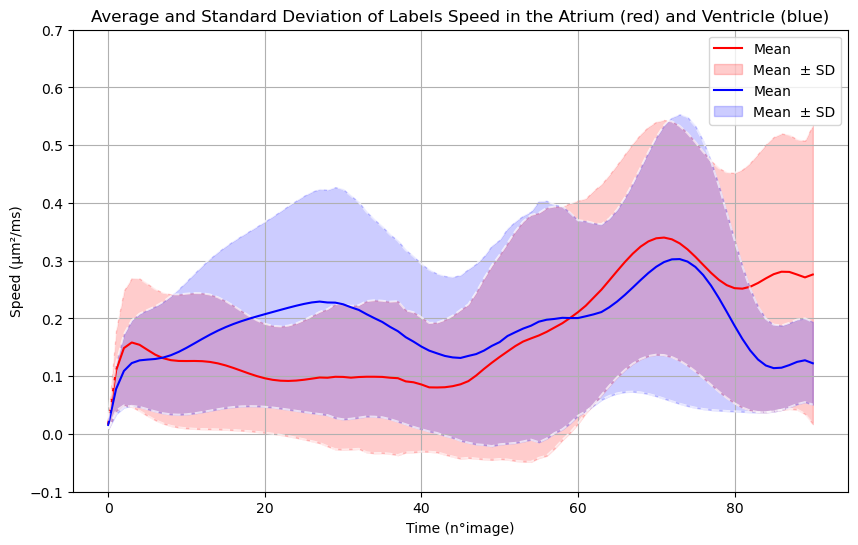

In [13]:
# Set the default renderer
pio.renderers.default = 'notebook'

norm_velocity_dict = {}

# New function to generate a random color in hexadecimal format for Matplotlib
def random_color_hex(existing_colors):
    while True:
        r, g, b = random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)
        color = "#{:02x}{:02x}{:02x}".format(r, g, b)
        if color not in existing_colors:
            existing_colors.add(color)
            return color

# Initialize the figure
fig = go.Figure()

# Initialize a set to track used colors
used_colors = set()

# Add trajectories for each point
for label in range(1, num_points + 1):  
    Vx = np.array([(data[j+1][label - 1, 1] - data[j][label - 1, 1])/delta for j in range(num_files-1)])
    Vy = np.array([(data[j+1][label - 1, 0] - data[j][label - 1, 0])/delta for j in range(num_files-1)])
    Vz = np.array([(data[j+1][label - 1, 2] - data[j][label - 1, 2])/delta for j in range(num_files-1)])
    V = np.sqrt(Vx**2 + Vy**2 + Vz**2)
    norm_velocity_dict[f'velocity_label_{label}']=V


    
# ATRIUM 
mean_velocity_in_Atrium_filtered = np.mean([norm_velocity_dict[f'velocity_label_{label}'] for label in Atrium_filtered], axis=0)
SD_velocity_in_Atrium_filtered = np.std([norm_velocity_dict[f'velocity_label_{label}'] for label in Atrium_filtered], axis=0)

smoothing_mean_Atrium_filtered = savgol_filter(mean_velocity_in_Atrium_filtered,55,10)
smoothing_mean_plus_SD_Atrium_filtered = savgol_filter(mean_velocity_in_Atrium_filtered + SD_velocity_in_Atrium_filtered,55,10)
smoothing_mean_less_SD_Atrium_filtered = savgol_filter(mean_velocity_in_Atrium_filtered - SD_velocity_in_Atrium_filtered,55,10)


# Create the figure and axes
plt.figure(figsize=(10, 6))
plt.grid(True)

# Plot the mean
#plt.plot(mean_velocity_in_Atrium_filtered, label='Mean', color='blue')

plt.plot(smoothing_mean_Atrium_filtered, label='Mean', color='red')

# Plot the mean + SD
#plt.plot(mean_velocity_in_Atrium_filtered + SD_velocity_in_Atrium_filtered, linestyle='--', color='blue', alpha=0.7, label='Mean + SD')

plt.plot(smoothing_mean_plus_SD_Atrium_filtered, linestyle='--', color='white', alpha=0.7)

# Plot the mean - SD
#plt.plot(mean_velocity_in_Atrium_filtered - SD_velocity_in_Atrium_filtered, linestyle='--', color='blue', alpha=0.7, label='Mean - SD')

plt.plot(smoothing_mean_less_SD_Atrium_filtered, linestyle='--', color='white', alpha=0.7)

# Fill the area between mean + standard deviation and mean - standard deviation
#plt.fill_between(range(len(mean_velocity_in_Atrium_filtered)), mean_velocity_in_Atrium_filtered + SD_velocity_in_Atrium_filtered, mean_velocity_in_Atrium_filtered - SD_velocity_in_Atrium_filtered, color='blue', alpha=0.2)

plt.fill_between(range(len(mean_velocity_in_Atrium_filtered)), smoothing_mean_plus_SD_Atrium_filtered, smoothing_mean_less_SD_Atrium_filtered, color='red', alpha=0.2, label = 'Mean  ± SD')

# VENTRICLE
mean_velocity_in_Ventricle_filtered = np.mean([norm_velocity_dict[f'velocity_label_{label}'] for label in Ventricle_filtered], axis=0)
SD_velocity_in_Ventricle_filtered = np.std([norm_velocity_dict[f'velocity_label_{label}'] for label in Ventricle_filtered], axis=0)

smoothing_mean_Ventricle_filtered = savgol_filter(mean_velocity_in_Ventricle_filtered,55,10)
smoothing_mean_plus_SD_Ventricle_filtered = savgol_filter(mean_velocity_in_Ventricle_filtered + SD_velocity_in_Ventricle_filtered,55,10)
smoothing_mean_less_SD_Ventricle_filtered = savgol_filter(mean_velocity_in_Ventricle_filtered - SD_velocity_in_Ventricle_filtered,55,10)


# Plot the mean
#plt.plot(mean_velocity_in_Ventricle_filtered, label='Mean', color='blue')

plt.plot(smoothing_mean_Ventricle_filtered, label='Mean', color='blue')

# Plot the mean + SD
#plt.plot(mean_velocity_in_Ventricle_filtered + SD_velocity_in_Ventricle_filtered, linestyle='--', color='blue', alpha=0.7, label='Mean + SD')

plt.plot(smoothing_mean_plus_SD_Ventricle_filtered, linestyle='--', color='white', alpha=0.7)

# Plot the mean - SD 
#plt.plot(mean_velocity_in_Ventricle_filtered - SD_velocity_in_Ventricle_filtered, linestyle='--', color='blue', alpha=0.7, label='Mean - SD')

plt.plot(smoothing_mean_less_SD_Ventricle_filtered, linestyle='--', color='white', alpha=0.7)

# Fill the area between mean + standard deviation and mean - standard deviation
#plt.fill_between(range(len(mean_velocity_in_Ventricle_filtered)), mean_velocity_in_Ventricle_filtered + SD_velocity_in_Atrium_filtered, mean_velocity_in_Ventricle_filtered - SD_velocity_in_Ventricle_filtered, color='blue', alpha=0.2)

plt.fill_between(range(len(mean_velocity_in_Ventricle_filtered)), smoothing_mean_plus_SD_Ventricle_filtered, smoothing_mean_less_SD_Ventricle_filtered, color='blue', alpha=0.2, label = 'Mean  ± SD')

# Configure the labels and legend
plt.xlabel('Time (n°image)')
plt.ylabel('Speed (µm/ms)')
plt.title('Average and Standard Deviation of Labels Speed in the Atrium (red) and Ventricle (blue)')
plt.legend()

plt.ylim(-0.1, 0.7)

# Display the plot
plt.show()

# C - Volume over time

This time, the MAD method was performed on a sample containing all the nuclei of the atrium and then on another with all the nuclei of the ventricle (not on one unique sample containing all labels).

Below is a program that calculates all the outliers in both samples.

In [8]:
# Set the default renderer
pio.renderers.default = 'notebook'

all_labels_at_t_dict = {}
labels_in_atrium_at_t_dict = {}
labels_in_ventricle_at_t_dict = {}

list_outliers_at_t_dict = {}
list_outliers_atrium_at_t_dict = {}
list_outliers_ventricle_at_t_dict = {}

outliers_all_time = []
outliers_all_time_ventricle = []
outliers_all_time_atrium = []

def mad(data1):
    median = np.median(data1)
    mad_value = np.median(np.abs(data1 - median))
    return mad_value

def detect_outliers_mad(data1, threshold=2.5):
    median = np.median(data1)
    mad = np.median(np.abs(data1 - median))
    outliers = np.abs(data1 - median) > threshold * mad
    return outliers

    
# Create a new dictionary to store the filtered data
filtered_volume_label_dict = {}


filtered_labels = []

volume_px_dict = {}

volume_label_dict = {}

volumes_dict = {}

for t in range(image.shape[0]): 
    # Access the data for the current t value
    slices_at_t = image[t, :, :, :]
    properties = regionprops(slices_at_t)
    volume_px_dict[f'vol_pix_at_t={t}'] = []
    for prop in properties:
        volume_px_dict[f'vol_pix_at_t={t}'].append((prop.label,(prop.area)*voxel_size[0]*voxel_size[1]*voxel_size[2]))
        x,y = zip(*volume_px_dict[f'vol_pix_at_t={t}'])
    for i in range(1,num_points+1):
        if i not in x :
            volume_px_dict[f'vol_pix_at_t={t}'].insert(i-1,(i,None))
            labels,volumes_dict[f'vol_at_t={t}'] = zip(*volume_px_dict[f'vol_pix_at_t={t}'])
            
# print(volumes_dict[f'vol_at_t={91}'] )

            
for label in range(1,num_points+1) :
    volume_label_dict[f'vol_label_{label}'] = []
    for t in range(image.shape[0]):
        volume_label_dict[f'vol_label_{label}'].append(volumes_dict[f'vol_at_t={t}'][label-1])
    if None in volume_label_dict[f'vol_label_{label}']:
        if label in Atrium :
            Atrium.remove(label)
        if label in Ventricle :
            Ventricle.remove(label)

#DELETE THE "Nones"

for label in range(1, num_points + 1):
    volume_data = volume_label_dict[f'vol_label_{label}']
    labels_in_atrium_at_t_dict[f't={t}'] = []
    labels_in_ventricle_at_t_dict[f't={t}'] = []
    # Check if there are any None values in the volume_data list
    if None not in volume_data:
        # If no None values are present, add this list to the new dictionary
        filtered_volume_label_dict[f'volume_label_{label}'] = volume_data
        filtered_labels.append(label)
        
            
for t in range(num_files-1):
    all_labels_at_t_dict[f't={t}']=[]
    
    list_outliers_at_t_dict[f't={t}']=[]
    list_outliers_atrium_at_t_dict[f't={t}'] = []
    list_outliers_ventricle_at_t_dict[f't={t}'] = []
    
    labels_in_atrium_at_t_dict[f't={t}'] = []
    labels_in_ventricle_at_t_dict[f't={t}'] = []
    
    for label in filtered_labels :
        all_labels_at_t_dict[f't={t}'].append((filtered_volume_label_dict[f'volume_label_{label}'][t],label))
        if label in Atrium :
            labels_in_atrium_at_t_dict[f't={t}'].append((filtered_volume_label_dict[f'volume_label_{label}'][t],label))
        if label in Ventricle :
            labels_in_ventricle_at_t_dict[f't={t}'].append((filtered_volume_label_dict[f'volume_label_{label}'][t],label))
    
    all_labels_at_t_dict[f't={t}'] = np.array(all_labels_at_t_dict[f't={t}'])
    labels_in_atrium_at_t_dict[f't={t}'] = np.array(labels_in_atrium_at_t_dict[f't={t}'])
#     print("labels_in_atrium_at_t_dict[f't={t}']",labels_in_atrium_at_t_dict[f't={t}'])
    labels_in_ventricle_at_t_dict[f't={t}'] = np.array(labels_in_ventricle_at_t_dict[f't={t}'])
#     print("labels_in_ventricle_at_t_dict[f't={t}']",labels_in_ventricle_at_t_dict[f't={t}'])
    
    #ATRIUM
           
#     print("all_labels_at_t_dict[f't={t}']:", all_labels_at_t_dict[f't={t}'])
#     print(len(all_labels_at_t_dict[f't={t}']))
    # Calculate the MAD for this label
    volume_at,label_at = zip(*labels_in_atrium_at_t_dict[f't={t}'])
    mad_value = mad(volume_at)
#     print(f"MAD for this label : {mad_value:.2f}")
    # Detect outliers for this label
    outliers_atrium = detect_outliers_mad(volume_at)
    position_atrium = np.where(outliers_atrium)[0]
    for i in range(len(position_atrium)):
        list_outliers_atrium_at_t_dict[f't={t}'].append(label_at[position_atrium[i]])
    # Display detected outliers and their indices
    # print(f"Outliers at t={t}:", all_labels_at_t_dict[f't={t}'][outliers])
    # print(f"Indices of poorly tracked labels at t={t}:", list_outliers_at_t_dict[f't={t}'])
    outliers_all_time_atrium.extend(list_outliers_atrium_at_t_dict[f't={t}'])


    #VENTRICLE 
    
#   print("all_labels_at_t_dict[f't={t}']:", all_labels_at_t_dict[f't={t}'])
#   print(len(all_labels_at_t_dict[f't={t}']))
    # Calculate the MAD for this label
    volume_vent,label_vent = zip(*labels_in_ventricle_at_t_dict[f't={t}'])
    mad_value = mad(volume_vent)
#     print(f"MAD for this label : {mad_value:.2f}")
    # Detect outliers for this label
    outliers_ventricle = detect_outliers_mad(volume_vent)
    position_ventricle = np.where(outliers_ventricle)[0]
#     print(position_ventricle)
    for i in range(len(position_ventricle)):
        list_outliers_ventricle_at_t_dict[f't={t}'].append(label_vent[position_ventricle[i]])
#         print("list_outliers_ventricle_at_t_dict[f't={t}']",list_outliers_ventricle_at_t_dict[f't={t}'])
    # Display detected outliers and their indices
    # print(f"Outliers at t={t}:", all_labels_at_t_dict[f't={t}'][outliers])
    # print(f"Indices of poorly tracked labels at t={t}:", list_outliers_at_t_dict[f't={t}'])
    outliers_all_time_ventricle.extend(list_outliers_ventricle_at_t_dict[f't={t}'])

#print("outliers_all_time_atrium", outliers_all_time_atrium)
#print("outliers_all_time_ventricle", outliers_all_time_ventricle)

outliers_atrium, freq_atrium = np.unique(outliers_all_time_atrium, return_counts=True) 
outliers_ventricle, freq_ventricle = np.unique(outliers_all_time_ventricle, return_counts=True)


Below is a program that displays a graph with all the labels of the Atrium that have been outliers with the number of times they were outliers, and a list of Atrium labels that were outliers more than **30 times** out of the 92 increments t.

In [9]:
# ATRIUM

threshold = 30

def filter_outliers_by_frequency(outliers, freq, threshold=30):
    # Filter outliers with a frequency greater than the threshold
    filtered_outliers = outliers[freq > threshold]
    return filtered_outliers

outliers_atrium, freq_atrium = np.unique(outliers_all_time_atrium, return_counts=True)    
# print("outliers_atrium", outliers_atrium)
# print("freq_atrium", freq_atrium)

fig_atrium = go.Figure(data=go.Scatter(x=outliers_atrium, y=freq_atrium, mode='lines+markers'))
fig_atrium.update_layout(
    title='Frequency of Outliers',
    xaxis_title='Outliers',
    yaxis_title='Frequency',
    width=1200,  # Width of the figure
    height=800,  # Height of the figure
)
# Display the figure with the 'iframe' renderer
fig_atrium.show(renderer="iframe")

#ATRIUM
# Filter outliers with a frequency greater than 30
high_freq_outliers_atrium = filter_outliers_by_frequency(outliers_atrium, freq_atrium, threshold=threshold)
print(f"Outliers with frequency greater than {threshold} in atrium:", high_freq_outliers_atrium)
# Remove the common elements between Atrium and high_freq_outliers from Atrium
Atrium_filtered = [item for item in Atrium if item not in high_freq_outliers_atrium]

Outliers with frequency greater than 30 in atrium: [ 20.  29.  43.  58.  70.  75.  80.  81.  86.  87.  96. 119. 123. 127.
 132. 136. 144. 148.]


Below is a program that displays a graph with all the labels of the Ventricle that have been outliers with the number of times they were outliers, and a list of Ventricle labels that were outliers more than **30 times** out of the 92 increments t.

In [10]:
# VENTRICLE

threshold = 30

def filter_outliers_by_frequency(outliers, freq, threshold=30):
    # Filter outliers with a frequency greater than the threshold
    filtered_outliers = outliers[freq > threshold]
    return filtered_outliers
   
outliers_ventricle, freq_ventricle = np.unique(outliers_all_time_ventricle, return_counts=True)
# print("outliers_ventricle", outliers_ventricle)

fig_ventricle = go.Figure(data=go.Scatter(x=outliers_ventricle, y=freq_ventricle, mode='lines+markers'))
fig_ventricle.update_layout(
    title='Frequency of Outliers',
    xaxis_title='Outliers',
    yaxis_title='Frequency',
    width=1200,  # Width of the figure
    height=800,  # Height of the figure
)
# Display the figure with the 'iframe' renderer
fig_ventricle.show(renderer="iframe")

#VENTRICLE
# Filter outliers with a frequency greater than 30
high_freq_outliers_ventricle = filter_outliers_by_frequency(outliers_ventricle, freq_ventricle, threshold=threshold)
print(f"Outliers with frequency greater than {threshold} in ventricle:", high_freq_outliers_ventricle)
# Remove the common elements between Ventricle and high_freq_outliers from Ventricle
Ventricle_filtered = [item for item in Ventricle if item not in high_freq_outliers_ventricle]

Outliers with frequency greater than 30 in ventricle: [215. 217. 275. 287. 292.]


- ## Average volume with standard deviation per class (atrium, ventricle) and cardiac phase (diastole, systole).

Unlike the same graph in the 'Data Analysis' notebook, this one was plotted by excluding from the average calculations the labels that were outliers in the Atrium and the Ventricle more than **30 times**.

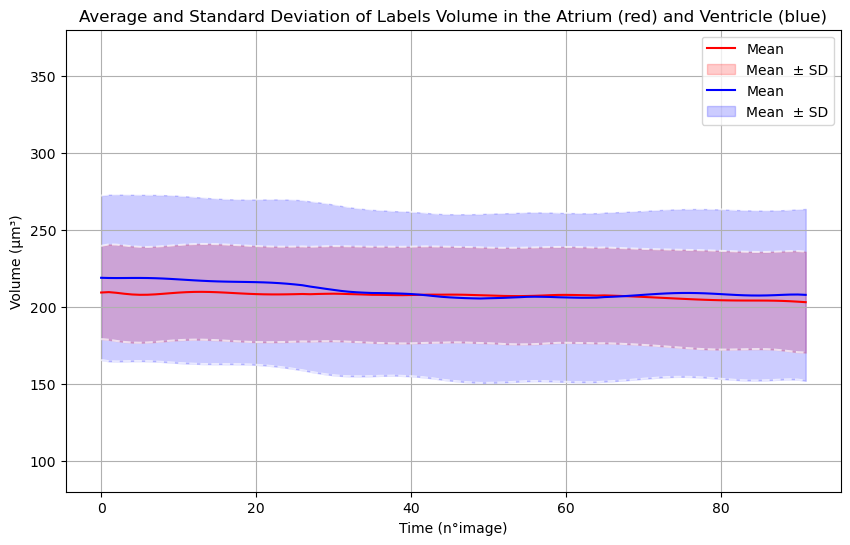

Execution time: 0.1562347412109375 secondes


In [14]:
from skimage import io

start_time = time.time()

# Set the default renderer
pio.renderers.default = 'notebook'


# Function to generate a unique random color
def random_color(existing_colors):
    while True:
        color = f'rgba({random.randint(0, 255)}, {random.randint(0, 255)}, {random.randint(0, 255)}, 1)'
        if color not in existing_colors:
            existing_colors.add(color)
            return color

# Initialize used colors and random colors
used_colors = set()


fig = go.Figure()
            
# ATRIUM 

mean_volume_in_Atrium = np.mean([volume_label_dict[f'vol_label_{label}'] for label in Atrium_filtered], axis=0)
SD_volume_in_Atrium = np.std([volume_label_dict[f'vol_label_{label}'] for label in Atrium_filtered], axis=0)

smoothing_mean_Atrium = savgol_filter(mean_volume_in_Atrium,55,10)
smoothing_mean_plus_SD_Atrium = savgol_filter(mean_volume_in_Atrium + SD_volume_in_Atrium,55,10)
smoothing_mean_less_SD_Atrium = savgol_filter(mean_volume_in_Atrium - SD_volume_in_Atrium,55,10)


# Create the figure and axes
plt.figure(figsize=(10, 6))
plt.grid(True)

# Plot the mean
#plt.plot(mean_volume_in_Atrium, label='Mean', color='blue')

plt.plot(smoothing_mean_Atrium, label='Mean', color='red')

# Plot the mean + SD
#plt.plot(mean_volume_in_Atrium + SD_volume_in_Atrium, linestyle='--', color='blue', alpha=0.7, label='Mean + SD')

plt.plot(smoothing_mean_plus_SD_Atrium, linestyle='--', color='white', alpha=0.7)

# Plot the mean - SD
#plt.plot(mean_volume_in_Atrium - SD_volume_in_Atrium, linestyle='--', color='blue', alpha=0.7, label='Mean - SD')

plt.plot(smoothing_mean_less_SD_Atrium, linestyle='--', color='white', alpha=0.7)

# Fill the area between mean + standard deviation and mean - standard deviation
#plt.fill_between(range(len(mean_volume_in_Atrium)), mean_volume_in_Atrium + SD_volume_in_Atrium, mean_volume_in_Atrium - SD_volume_in_Atrium, color='blue', alpha=0.2)

plt.fill_between(range(len(mean_volume_in_Atrium)), smoothing_mean_plus_SD_Atrium, smoothing_mean_less_SD_Atrium, color='red', alpha=0.2, label = 'Mean  ± SD')


# VENTRICLE

mean_volume_in_Ventricle = np.mean([volume_label_dict[f'vol_label_{label}'] for label in Ventricle_filtered], axis=0)
SD_volume_in_Ventricle = np.std([volume_label_dict[f'vol_label_{label}'] for label in Ventricle_filtered], axis=0)

smoothing_mean_Ventricle = savgol_filter(mean_volume_in_Ventricle,55,10)
smoothing_mean_plus_SD_Ventricle = savgol_filter(mean_volume_in_Ventricle + SD_volume_in_Ventricle,55,10)
smoothing_mean_less_SD_Ventricle = savgol_filter(mean_volume_in_Ventricle - SD_volume_in_Ventricle,55,10)

# Plot the mean
#plt.plot(mean_volume_in_Ventricle, label='Mean', color='blue')

plt.plot(smoothing_mean_Ventricle, label='Mean', color='blue')

# Plot the mean + SD
#plt.plot(mean_volume_in_Ventricle + SD_volume_in_Ventricle, linestyle='--', color='blue', alpha=0.7, label='Mean + SD')

plt.plot(smoothing_mean_plus_SD_Ventricle, linestyle='--', color='white', alpha=0.7)

# Plot the mean - SD
#plt.plot(mean_volume_in_Ventricle - SD_volume_in_Ventricle, linestyle='--', color='blue', alpha=0.7, label='Mean - SD')

plt.plot(smoothing_mean_less_SD_Ventricle, linestyle='--', color='white', alpha=0.7)

# Fill the area between mean + standard deviation and mean - standard deviation
#plt.fill_between(range(len(mean_volume_in_Ventricle)), mean_volumey_in_Ventricle + SD_volume_in_Atrium, mean_volume_in_Ventricle - SD_volume_in_Ventricle, color='blue', alpha=0.2)

plt.fill_between(range(len(mean_volume_in_Ventricle)), smoothing_mean_plus_SD_Ventricle, smoothing_mean_less_SD_Ventricle, color='blue', alpha=0.2, label = 'Mean  ± SD')

# Configure y-axis limits
plt.ylim(80, 380)

# Configure the labels and legend
plt.xlabel('Time (n°image)')
plt.ylabel('Volume (µm³)')
plt.title('Average and Standard Deviation of Labels Volume in the Atrium (red) and Ventricle (blue)')
plt.legend()

# Display the plot
plt.show()

end_time = time.time()

execution_time = end_time - start_time
print("Execution time:", execution_time, "secondes")

# D - Solidity over time (V/Vconv)

The calculation of the Convex Hull Area is necessary for determining solidity.

- ## Calculation of Convex Hull Area (Vconv)

In [11]:
from skimage import io

start_time = time.time()

area_convex_dict = {}

new_area_convex_dict = {}

area_convex_label_dict = {}

fig = go.Figure()

for t in range(image.shape[0]): 
    # Access the data for the current t value
    slices_at_t = image[t, :, :, :]
    properties = regionprops(slices_at_t)
    area_convex_dict[f'area_convex_at_t={t}'] = []
    for prop in properties:
        area_convex_dict[f'area_convex_at_t={t}'].append((prop.label,(prop.area_convex)*voxel_size[0]*voxel_size[1]*voxel_size[2]))
        x,y = zip(*area_convex_dict[f'area_convex_at_t={t}'])
    for i in range(1,num_points+1):
        if i not in x :
            area_convex_dict[f'area_convex_at_t={t}'].insert(i-1,(i,None))
            labels,new_area_convex_dict[f'vol_at_t={t}'] = zip(*area_convex_dict[f'area_convex_at_t={t}'])

for label in range(1,num_points+1) :
    area_convex_label_dict[f'conv_label_{label}'] = []
    for t in range(image.shape[0]):
        area_convex_label_dict[f'conv_label_{label}'].append(new_area_convex_dict[f'vol_at_t={t}'][label-1])


end_time = time.time()

execution_time = end_time - start_time

print("Execution time:", execution_time, "secondes")

Execution time: 71.62778949737549 secondes


The MAD method was performed on a sample containing all the nuclei of the atrium and then on another with all the nuclei of the ventricle (not on one unique sample containing all labels).

Below is a program that calculates all the outliers in both samples.

In [12]:
# Set the default renderer
pio.renderers.default = 'notebook'

all_labels_at_t_dict = {}
labels_in_atrium_at_t_dict = {}
labels_in_ventricle_at_t_dict = {}

list_outliers_at_t_dict = {}
list_outliers_atrium_at_t_dict = {}
list_outliers_ventricle_at_t_dict = {}

outliers_all_time = []
outliers_all_time_ventricle = []
outliers_all_time_atrium = []

def mad(data1):
    median = np.median(data1)
    mad_value = np.median(np.abs(data1 - median))
    return mad_value

def detect_outliers_mad(data1, threshold=2.5):
    median = np.median(data1)
    mad = np.median(np.abs(data1 - median))
    outliers = np.abs(data1 - median) > threshold * mad
    return outliers

    
# Create a new dictionary to store the filtered data
filtered_solidity_label_dict = {}


filtered_labels = []

solidity_px_dict = {}

solidity_label_dict = {}

solidity_dict = {}


solidity_label_dict = {}

for label in range(1,num_points+1) :
    solidity_label_dict[f'solidity_label_{label}'] = []
    for t in range(image.shape[0]):
        if volume_label_dict[f'vol_label_{label}'][t] != None :
            solidity_label_dict[f'solidity_label_{label}'].append(volume_label_dict[f'vol_label_{label}'][t]/area_convex_label_dict[f'conv_label_{label}'][t])
        else :
            solidity_label_dict[f'solidity_label_{label}'].append(None)
            
    if None in solidity_label_dict[f'solidity_label_{label}']:
        if label in Atrium :
            Atrium.remove(label)
        if label in Ventricle :
            Ventricle.remove(label)

#DELETE THE "NONES"

for label in range(1, num_points + 1):
    solidity_data = solidity_label_dict[f'solidity_label_{label}']
    labels_in_atrium_at_t_dict[f't={t}'] = []
    labels_in_ventricle_at_t_dict[f't={t}'] = []
    # Check if there are any None values in the solidity_data list
    if None not in solidity_data:
        # If no None values are present, add this list to the new dictionary
        filtered_solidity_label_dict[f'solidity_label_{label}'] = solidity_data
        filtered_labels.append(label)
        
            
    
for t in range(num_files-1):
    all_labels_at_t_dict[f't={t}']=[]
    
    list_outliers_at_t_dict[f't={t}']=[]
    list_outliers_atrium_at_t_dict[f't={t}'] = []
    list_outliers_ventricle_at_t_dict[f't={t}'] = []
    
    labels_in_atrium_at_t_dict[f't={t}'] = []
    labels_in_ventricle_at_t_dict[f't={t}'] = []
    
    for label in filtered_labels :
        all_labels_at_t_dict[f't={t}'].append((filtered_solidity_label_dict[f'solidity_label_{label}'][t],label))
        if label in Atrium :
            labels_in_atrium_at_t_dict[f't={t}'].append((filtered_solidity_label_dict[f'solidity_label_{label}'][t],label))
        if label in Ventricle :
            labels_in_ventricle_at_t_dict[f't={t}'].append((filtered_solidity_label_dict[f'solidity_label_{label}'][t],label))
    
    all_labels_at_t_dict[f't={t}'] = np.array(all_labels_at_t_dict[f't={t}'])
    labels_in_atrium_at_t_dict[f't={t}'] = np.array(labels_in_atrium_at_t_dict[f't={t}'])
#     print("labels_in_atrium_at_t_dict[f't={t}']",labels_in_atrium_at_t_dict[f't={t}'])
    labels_in_ventricle_at_t_dict[f't={t}'] = np.array(labels_in_ventricle_at_t_dict[f't={t}'])
#     print("labels_in_ventricle_at_t_dict[f't={t}']",labels_in_ventricle_at_t_dict[f't={t}'])
    
    #ATRIUM
           
#     print("all_labels_at_t_dict[f't={t}']:", all_labels_at_t_dict[f't={t}'])
#     print(len(all_labels_at_t_dict[f't={t}']))
    # Calculate the MAD for this label
    solidity_at,label_at = zip(*labels_in_atrium_at_t_dict[f't={t}'])
    mad_value = mad(solidity_at)
#     print(f"MAD for this label : {mad_value:.2f}")
    # Detect outliers for this label
    outliers_atrium = detect_outliers_mad(solidity_at)
    position_atrium = np.where(outliers_atrium)[0]
    for i in range(len(position_atrium)):
        list_outliers_atrium_at_t_dict[f't={t}'].append(label_at[position_atrium[i]])
    # Display detected outliers and their indices
    # print(f"Outliers at t={t}:", all_labels_at_t_dict[f't={t}'][outliers])
    # print(f"Indices of poorly tracked labels at t={t}:", list_outliers_at_t_dict[f't={t}'])
    outliers_all_time_atrium.extend(list_outliers_atrium_at_t_dict[f't={t}'])


    #VENTRICLE 
    
#   print("all_labels_at_t_dict[f't={t}']:", all_labels_at_t_dict[f't={t}'])
#   print(len(all_labels_at_t_dict[f't={t}']))
    # Calculate the MAD for this label
    solidity_vent,label_vent = zip(*labels_in_ventricle_at_t_dict[f't={t}'])
    mad_value = mad(solidity_vent)
#     print(f"MAD for this label : {mad_value:.2f}")
    # Detect outliers for this label
    outliers_ventricle = detect_outliers_mad(solidity_vent)
    position_ventricle = np.where(outliers_ventricle)[0]
#     print(position_ventricle)
    for i in range(len(position_ventricle)):
        list_outliers_ventricle_at_t_dict[f't={t}'].append(label_vent[position_ventricle[i]])
#         print("list_outliers_ventricle_at_t_dict[f't={t}']",list_outliers_ventricle_at_t_dict[f't={t}'])
    # Display detected outliers and their indices
    # print(f"Outliers at t={t}:", all_labels_at_t_dict[f't={t}'][outliers])
    # print(f"Indices of poorly tracked labels at t={t}:", list_outliers_at_t_dict[f't={t}'])
    outliers_all_time_ventricle.extend(list_outliers_ventricle_at_t_dict[f't={t}'])

#print("outliers_all_time_atrium", outliers_all_time_atrium)
#print("outliers_all_time_ventricle", outliers_all_time_ventricle)

outliers_atrium, freq_atrium = np.unique(outliers_all_time_atrium, return_counts=True) 
outliers_ventricle, freq_ventricle = np.unique(outliers_all_time_ventricle, return_counts=True)

Below is a program that displays a graph with all the labels of the Atrium that have been outliers with the number of times they were outliers, and a list of Atrium labels that were outliers more than **30 times** out of the 92 increments t.

In [13]:
# ATRIUM

threshold = 30

def filter_outliers_by_frequency(outliers, freq, threshold=30):
    # Filter outliers with a frequency greater than the threshold
    filtered_outliers = outliers[freq > threshold]
    return filtered_outliers

outliers_atrium, freq_atrium = np.unique(outliers_all_time_atrium, return_counts=True)    
# print("outliers_atrium", outliers_atrium)
# print("freq_atrium", freq_atrium)

fig_atrium = go.Figure(data=go.Scatter(x=outliers_atrium, y=freq_atrium, mode='lines+markers'))
fig_atrium.update_layout(
    title='Frequency of Outliers',
    xaxis_title='Outliers',
    yaxis_title='Frequency',
    width=1200,  # Width of the figure
    height=800,  # Height of the figure
)
# Display the figure with the 'iframe' renderer
fig_atrium.show(renderer="iframe")

#ATRIUM
# Filter outliers with a frequency greater than 30
high_freq_outliers_atrium = filter_outliers_by_frequency(outliers_atrium, freq_atrium, threshold=threshold)
print(f"Outliers with frequency greater than {threshold} in atrium:", high_freq_outliers_atrium)
# Remove the common elements between Atrium and high_freq_outliers from Atrium
Atrium_filtered = [item for item in Atrium if item not in high_freq_outliers_atrium]

Outliers with frequency greater than 30 in atrium: [ 23.  36.  37.  86. 102. 104. 122. 132. 142. 148.]


Below is a program that displays a graph with all the labels of the Ventricle that have been outliers with the number of times they were outliers, and a list of Ventricle labels that were outliers more than **30 times** out of the 92 increments t.

In [15]:
# VENTRICLE

threshold = 30

def filter_outliers_by_frequency(outliers, freq, threshold=30):
    # Filter outliers with a frequency greater than the threshold
    filtered_outliers = outliers[freq > threshold]
    return filtered_outliers
   
outliers_ventricle, freq_ventricle = np.unique(outliers_all_time_ventricle, return_counts=True)
# print("outliers_ventricle", outliers_ventricle)

fig_ventricle = go.Figure(data=go.Scatter(x=outliers_ventricle, y=freq_ventricle, mode='lines+markers'))
fig_ventricle.update_layout(
    title='Frequency of Outliers',
    xaxis_title='Outliers',
    yaxis_title='Frequency',
    width=1200,  # Width of the figure
    height=800,  # Height of the figure
)
# Display the figure with the 'iframe' renderer
fig_ventricle.show(renderer="iframe")

#VENTRICLE
# Filter outliers with a frequency greater than 30
high_freq_outliers_ventricle = filter_outliers_by_frequency(outliers_ventricle, freq_ventricle, threshold=threshold)
print(f"Outliers with frequency greater than {threshold} in ventricle:", high_freq_outliers_ventricle)
# Remove the common elements between Ventricle and high_freq_outliers from Ventricle
Ventricle_filtered = [item for item in Ventricle if item not in high_freq_outliers_ventricle]

Outliers with frequency greater than 30 in ventricle: [151. 166. 175. 194. 212. 225.]


- ## Average solidy with standard deviation per class (atrium, ventricle) and cardiac phase (diastole, systole).

Unlike the same graph in the 'Data Analysis' notebook, this one was plotted by excluding from the average calculations the labels that were outliers in the Atrium and the Ventricle more than **30 times**.

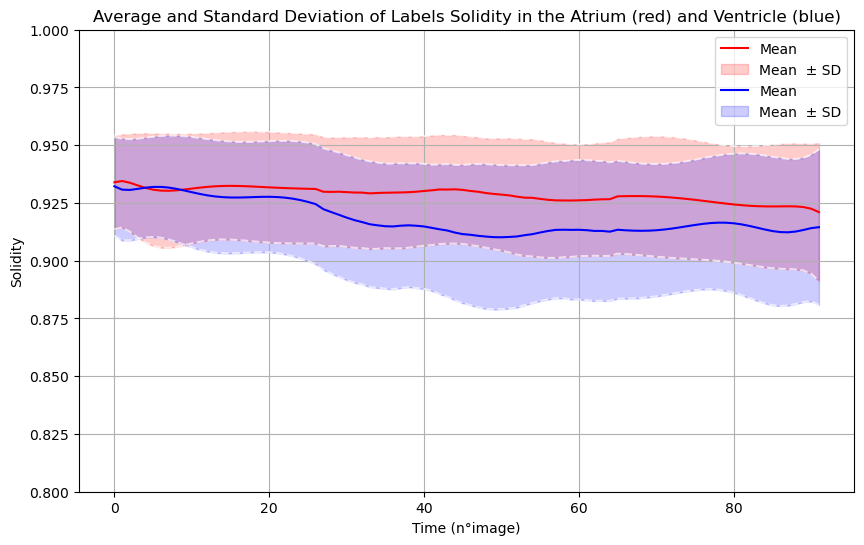

Execution time: 0.16421747207641602 secondes


In [19]:
from skimage import io

start_time = time.time()
            
# ATRIUM 

mean_solidity_in_Atrium = np.mean([solidity_label_dict[f'solidity_label_{label}'] for label in Atrium_filtered], axis=0)
SD_solidity_in_Atrium = np.std([solidity_label_dict[f'solidity_label_{label}'] for label in Atrium_filtered], axis=0)

smoothing_mean_Atrium = savgol_filter(mean_solidity_in_Atrium,55,10)
smoothing_mean_plus_SD_Atrium = savgol_filter(mean_solidity_in_Atrium + SD_solidity_in_Atrium,55,10)
smoothing_mean_less_SD_Atrium = savgol_filter(mean_solidity_in_Atrium - SD_solidity_in_Atrium,55,10)


# Create the figure and axes
plt.figure(figsize=(10, 6))
plt.grid(True)

# Plot the mean
#plt.plot(mean__in_Atrium, label='Mean', color='blue')

plt.plot(smoothing_mean_Atrium, label='Mean', color='red')

# Plot the mean + SD
#plt.plot(mean_solidity_in_Atrium + SD_solidity_in_Atrium, linestyle='--', color='blue', alpha=0.7, label='Mean + SD')

plt.plot(smoothing_mean_plus_SD_Atrium, linestyle='--', color='white', alpha=0.7)

# Plot the mean - SD
#plt.plot(mean_solidity_in_Atrium - SD_solidity_in_Atrium, linestyle='--', color='blue', alpha=0.7, label='Mean - SD')

plt.plot(smoothing_mean_less_SD_Atrium, linestyle='--', color='white', alpha=0.7)

# Fill the area between mean + standard deviation and mean - standard deviation
#plt.fill_between(range(len(mean_solidity_in_Atrium)), mean_solidity_in_Atrium + SD_solidity_in_Atrium, mean_solidity_in_Atrium - SD_solidity_in_Atrium, color='blue', alpha=0.2)

plt.fill_between(range(len(mean_solidity_in_Atrium)), smoothing_mean_plus_SD_Atrium, smoothing_mean_less_SD_Atrium, color='red', alpha=0.2, label = 'Mean  ± SD')



# VENTRICLE

mean_solidity_in_Ventricle = np.mean([solidity_label_dict[f'solidity_label_{label}'] for label in Ventricle_filtered], axis=0)
SD_solidity_in_Ventricle = np.std([solidity_label_dict[f'solidity_label_{label}'] for label in Ventricle_filtered], axis=0)

smoothing_mean_Ventricle = savgol_filter(mean_solidity_in_Ventricle,55,10)
smoothing_mean_plus_SD_Ventricle = savgol_filter(mean_solidity_in_Ventricle + SD_solidity_in_Ventricle,55,10)
smoothing_mean_less_SD_Ventricle = savgol_filter(mean_solidity_in_Ventricle - SD_solidity_in_Ventricle,55,10)

# Plot the mean
#plt.plot(mean_solidity_in_Ventricle, label='Mean', color='blue')

plt.plot(smoothing_mean_Ventricle, label='Mean', color='blue')

# Plot the mean + SD
#plt.plot(mean_solidity_in_Ventricle + SD_solidity_in_Ventricle, linestyle='--', color='blue', alpha=0.7, label='Mean + SD')

plt.plot(smoothing_mean_plus_SD_Ventricle, linestyle='--', color='white', alpha=0.7)

# Plot the mean - SD
#plt.plot(mean_solidity_in_Ventricle - SD_solidity_in_Ventricle, linestyle='--', color='blue', alpha=0.7, label='Mean - SD')

plt.plot(smoothing_mean_less_SD_Ventricle, linestyle='--', color='white', alpha=0.7)

# Fill the area between mean + standard deviation and mean - standard deviation
#plt.fill_between(range(len(mean_solidity_in_Ventricle)), mean_solidity_in_Ventricle + SD_solidity_in_Atrium, mean_solidity_in_Ventricle - SD_solidity_in_Ventricle, color='blue', alpha=0.2)

plt.fill_between(range(len(mean_solidity_in_Ventricle)), smoothing_mean_plus_SD_Ventricle, smoothing_mean_less_SD_Ventricle, color='blue', alpha=0.2, label = 'Mean  ± SD')

# diff = smoothing_mean_Atrium - smoothing_mean_Ventricle
# sign_changes = np.where(np.diff(np.sign(diff)))[0]

# # Tracer les points d'intersection avec annotation
# for idx in sign_changes:
#     plt.plot(idx, smoothing_mean_Atrium[idx], 'go')  # Marquer le point d'intersection avec un point vert
#     plt.annotate(f'({idx}, {smoothing_mean_Atrium[idx]:.2f})', xy=(idx, smoothing_mean_Atrium[idx]), xytext=(idx + 5, smoothing_mean_Atrium[idx] + 0.1),
#                  arrowprops=dict(facecolor='black', arrowstyle='->'), fontsize=10, ha='left', va='bottom')


# Configure y-axis limits
plt.ylim(0.8, 1)

# Configure the labels and legend
plt.xlabel('Time (n°image)')
plt.ylabel('Solidity')
plt.title('Average and Standard Deviation of Labels Solidity in the Atrium (red) and Ventricle (blue)')
plt.legend()

# Display the plot
plt.show()

end_time = time.time()


execution_time = end_time - start_time
print("Execution time:", execution_time, "secondes")

# E - Sphericity over time

In [12]:
Atrium.remove(74)  # Manually remove labels if they decrease the quality of the result

The MAD method was performed on a sample containing all the nuclei of the atrium and then on another with all the nuclei of the ventricle (not on one unique sample containing all labels).

Below is a program that calculates all the outliers in both samples.

In [16]:
from skimage import io

# Set the default renderer
pio.renderers.default = 'notebook'

all_labels_at_t_dict = {}
labels_in_atrium_at_t_dict = {}
labels_in_ventricle_at_t_dict = {}


list_outliers_at_t_dict = {}
list_outliers_atrium_at_t_dict = {}
list_outliers_ventricle_at_t_dict = {}

outliers_all_time = []
outliers_all_time_ventricle = []
outliers_all_time_atrium = []

# def mad(data1):
#     median = np.median(data1)
#     mad_value = np.median(np.abs(data1 - median))
#     return mad_value

def detect_outliers_mad(data1, threshold=2.5):
    median = np.median(data1)
    mad = np.median(np.abs(data1 - median))
    outliers = np.abs(data1 - median) > threshold * mad
    return outliers

    
# Create a new dictionary to store the filtered data
filtered_sphericity_label_dict = {}

filtered_labels = []

start_time = time.time()


def read_surface_area_file(file_path):
    with open(file_path, 'r') as file:
        data = file.readlines()

    surface_area_label_dict = {}
    for line in data:
        if ':' in line:
            key, value = line.split(':')
            key = key.strip()
            value = value.strip().strip('[]')
            value_list = []
            for v in value.split(','):
                v = v.strip()
                if v == 'None':
                    value_list.append(None)
                else:
                    value_list.append(float(v))
            surface_area_label_dict[key] = value_list

    return surface_area_label_dict

# Path to the text file
file_path = 'surface_area (SA) LoG.txt'

# Reading and parsing the file
surface_area_label_dict = read_surface_area_file(file_path)



sphericity_label_dict = {}

for label in range(1,num_points+1) :
    sphericity_label_dict[f'sphericity_label_{label}'] = []    
    for t in range(image.shape[0]):
        if volume_label_dict[f'vol_label_{label}'][t] != None :
            sphericity_label_dict[f'sphericity_label_{label}'].append((np.pi ** (1 / 3)) * ((6 * volume_label_dict[f'vol_label_{label}'][t]) ** (2 / 3))/surface_area_label_dict[f'SA_label_{label}'][t])
        else :
            sphericity_label_dict[f'sphericity_label_{label}'].append(None)        
    if None in sphericity_label_dict[f'sphericity_label_{label}']:
        if label in Atrium :
            Atrium.remove(label)
        if label in Ventricle :
            Ventricle.remove(label)
            
for label in range(1, num_points + 1):
    sphericity_data = sphericity_label_dict[f'sphericity_label_{label}']
    labels_in_atrium_at_t_dict[f't={t}'] = []
    labels_in_ventricle_at_t_dict[f't={t}'] = []
    # Check if there are any None values in the sphericity_data list
    if None not in sphericity_data:
        # If no None values are present, add this list to the new dictionary
        filtered_sphericity_label_dict[f'sphericity_label_{label}'] = sphericity_data
        filtered_labels.append(label)
        
    
for t in range(num_files-1):
    all_labels_at_t_dict[f't={t}']=[]
    
    list_outliers_at_t_dict[f't={t}']=[]
    list_outliers_atrium_at_t_dict[f't={t}'] = []
    list_outliers_ventricle_at_t_dict[f't={t}'] = []
    
    labels_in_atrium_at_t_dict[f't={t}'] = []
    labels_in_ventricle_at_t_dict[f't={t}'] = []
    
    for label in filtered_labels :
        all_labels_at_t_dict[f't={t}'].append((filtered_sphericity_label_dict[f'sphericity_label_{label}'][t],label))
        if label in Atrium :
            labels_in_atrium_at_t_dict[f't={t}'].append((filtered_sphericity_label_dict[f'sphericity_label_{label}'][t],label))
        if label in Ventricle :
            labels_in_ventricle_at_t_dict[f't={t}'].append((filtered_sphericity_label_dict[f'sphericity_label_{label}'][t],label))
    
    all_labels_at_t_dict[f't={t}'] = np.array(all_labels_at_t_dict[f't={t}'])
    labels_in_atrium_at_t_dict[f't={t}'] = np.array(labels_in_atrium_at_t_dict[f't={t}'])
#     print("labels_in_atrium_at_t_dict[f't={t}']",labels_in_atrium_at_t_dict[f't={t}'])
    labels_in_ventricle_at_t_dict[f't={t}'] = np.array(labels_in_ventricle_at_t_dict[f't={t}'])
#     print("labels_in_ventricle_at_t_dict[f't={t}']",labels_in_ventricle_at_t_dict[f't={t}'])
    
    #ATRIUM
           
#     print("all_labels_at_t_dict[f't={t}']:", all_labels_at_t_dict[f't={t}'])
#     print(len(all_labels_at_t_dict[f't={t}']))
    # Calculate the MAD for this label
    sphericity_at,label_at = zip(*labels_in_atrium_at_t_dict[f't={t}'])
    mad_value = mad(sphericity_at)
#     print(f"MAD for this label : {mad_value:.2f}")
    # Detect outliers for this label
    outliers_atrium = detect_outliers_mad(sphericity_at)
    position_atrium = np.where(outliers_atrium)[0]
    for i in range(len(position_atrium)):
        list_outliers_atrium_at_t_dict[f't={t}'].append(label_at[position_atrium[i]])
    # Display detected outliers and their indices
    # print(f"Outliers at t={t}:", all_labels_at_t_dict[f't={t}'][outliers])
    # print(f"Indices of poorly tracked labels at t={t}:", list_outliers_at_t_dict[f't={t}'])
    outliers_all_time_atrium.extend(list_outliers_atrium_at_t_dict[f't={t}'])


    #VENTRICLE 
    
#   print("all_labels_at_t_dict[f't={t}']:", all_labels_at_t_dict[f't={t}'])
#   print(len(all_labels_at_t_dict[f't={t}']))
    # Calculate the MAD for this label
    sphericity_vent,label_vent = zip(*labels_in_ventricle_at_t_dict[f't={t}'])
    mad_value = mad(sphericity_vent)
#     print(f"MAD for this label : {mad_value:.2f}")
    # Detect outliers for this label
    outliers_ventricle = detect_outliers_mad(sphericity_vent)
    position_ventricle = np.where(outliers_ventricle)[0]
#     print(position_ventricle)
    for i in range(len(position_ventricle)):
        list_outliers_ventricle_at_t_dict[f't={t}'].append(label_vent[position_ventricle[i]])
#         print("list_outliers_ventricle_at_t_dict[f't={t}']",list_outliers_ventricle_at_t_dict[f't={t}'])
    # Display detected outliers and their indices
    # print(f"Outliers at t={t}:", all_labels_at_t_dict[f't={t}'][outliers])
    # print(f"Indices of poorly tracked labels at t={t}:", list_outliers_at_t_dict[f't={t}'])
    outliers_all_time_ventricle.extend(list_outliers_ventricle_at_t_dict[f't={t}'])

# print("outliers_all_time_atrium", outliers_all_time_atrium)
# print("outliers_all_time_ventricle", outliers_all_time_ventricle)

outliers_atrium, freq_atrium = np.unique(outliers_all_time_atrium, return_counts=True) 
outliers_ventricle, freq_ventricle = np.unique(outliers_all_time_ventricle, return_counts=True)



Below is a program that displays a graph with all the labels of the Atrium that have been outliers with the number of times they were outliers, and a list of Atrium labels that were outliers more than **30 times** out of the 92 increments t.

In [17]:
# ATRIUM

threshold = 30

def filter_outliers_by_frequency(outliers, freq, threshold=30):
    # Filter outliers with a frequency greater than the threshold
    filtered_outliers = outliers[freq > threshold]
    return filtered_outliers

outliers_atrium, freq_atrium = np.unique(outliers_all_time_atrium, return_counts=True)    
# print("outliers_atrium", outliers_atrium)
# print("freq_atrium", freq_atrium)

fig_atrium = go.Figure(data=go.Scatter(x=outliers_atrium, y=freq_atrium, mode='lines+markers'))
fig_atrium.update_layout(
    title='Frequency of Outliers',
    xaxis_title='Outliers',
    yaxis_title='Frequency',
    width=1200,  # Width of the figure
    height=800,  # Height of the figure
)
# Display the figure with the 'iframe' renderer
fig_atrium.show(renderer="iframe")

#ATRIUM
# Filter outliers with a frequency greater than 30
high_freq_outliers_atrium = filter_outliers_by_frequency(outliers_atrium, freq_atrium, threshold=threshold)
print(f"Outliers with frequency greater than {threshold} in atrium:", high_freq_outliers_atrium)
# Remove the common elements between Atrium and high_freq_outliers from Atrium
Atrium_filtered = [item for item in Atrium if item not in high_freq_outliers_atrium]

Outliers with frequency greater than 30 in atrium: [ 15.  36.  52.  58.  86. 122. 132. 135. 142. 148.]


Below is a program that displays a graph with all the labels of the Ventricle that have been outliers with the number of times they were outliers, and a list of Ventricle labels that were outliers more than **30 times** out of the 92 increments t.

In [18]:
# VENTRICLE

threshold = 30

def filter_outliers_by_frequency(outliers, freq, threshold=30):
    # Filter outliers with a frequency greater than the threshold
    filtered_outliers = outliers[freq > threshold]
    return filtered_outliers
   
outliers_ventricle, freq_ventricle = np.unique(outliers_all_time_ventricle, return_counts=True)
# print("outliers_ventricle", outliers_ventricle)

fig_ventricle = go.Figure(data=go.Scatter(x=outliers_ventricle, y=freq_ventricle, mode='lines+markers'))
fig_ventricle.update_layout(
    title='Frequency of Outliers',
    xaxis_title='Outliers',
    yaxis_title='Frequency',
    width=1200,  # Width of the figure
    height=800,  # Height of the figure
)
# Display the figure with the 'iframe' renderer
fig_ventricle.show(renderer="iframe")

#VENTRICLE
# Filter outliers with a frequency greater than 30
high_freq_outliers_ventricle = filter_outliers_by_frequency(outliers_ventricle, freq_ventricle, threshold=threshold)
print(f"Outliers with frequency greater than {threshold} in ventricle:", high_freq_outliers_ventricle)
# Remove the common elements between Ventricle and high_freq_outliers from Ventricle
Ventricle_filtered = [item for item in Ventricle if item not in high_freq_outliers_ventricle]

Outliers with frequency greater than 30 in ventricle: [138. 151. 194. 212. 215. 219. 223. 225. 238. 267. 281. 292.]


- ## Average sphericity with standard deviation per class (atrium, ventricle) and cardiac phase (diastole, systole).

Unlike the same graph in the 'Data Analysis' notebook, this one was plotted by excluding from the average calculations the labels that were outliers in the Atrium and the Ventricle more than **30 times**.

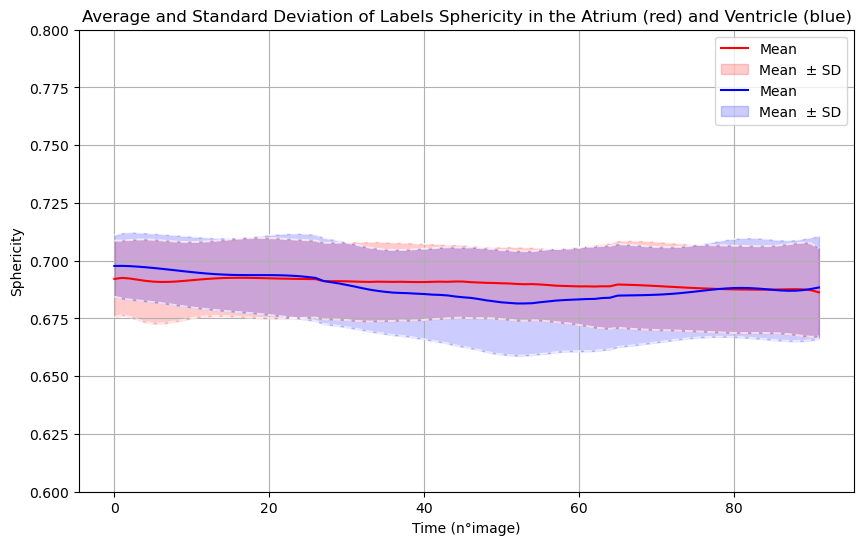

Execution time: 0.23672890663146973 secondes


In [21]:
from skimage import io

start_time = time.time()


def read_surface_area_file(file_path):
    with open(file_path, 'r') as file:
        data = file.readlines()

    surface_area_label_dict = {}
    for line in data:
        if ':' in line:
            key, value = line.split(':')
            key = key.strip()
            value = value.strip().strip('[]')
            value_list = []
            for v in value.split(','):
                v = v.strip()
                if v == 'None':
                    value_list.append(None)
                else:
                    value_list.append(float(v))
            surface_area_label_dict[key] = value_list

    return surface_area_label_dict

# Path to the text file
file_path = 'surface_area (SA) LoG.txt'

# Reading and parsing the file
surface_area_label_dict = read_surface_area_file(file_path)



sphericity_label_dict = {}

for label in range(1,num_points+1) :
    sphericity_label_dict[f'sphericity_label_{label}'] = []    
    for t in range(image.shape[0]):
        if volume_label_dict[f'vol_label_{label}'][t] != None and surface_area_label_dict[f'SA_label_{label}'][t] is not None:
            sphericity_label_dict[f'sphericity_label_{label}'].append((np.pi ** (1 / 3)) * ((6 * volume_label_dict[f'vol_label_{label}'][t]) ** (2 / 3))/surface_area_label_dict[f'SA_label_{label}'][t])
        else :
            sphericity_label_dict[f'sphericity_label_{label}'].append(None)        
    if None in sphericity_label_dict[f'sphericity_label_{label}']:
        if label in Atrium_filtered :
            Atrium_filtered.remove(label)
        if label in Ventricle_filtered :
            Atrium_filtered.remove(label)
            
# ATRIUM 

mean_sphericity_in_Atrium = np.mean([sphericity_label_dict[f'sphericity_label_{label}'] for label in Atrium_filtered], axis=0)
SD_sphericity_in_Atrium = np.std([sphericity_label_dict[f'sphericity_label_{label}'] for label in Atrium_filtered], axis=0)

smoothing_mean_Atrium = savgol_filter(mean_sphericity_in_Atrium,55,10)
smoothing_mean_plus_SD_Atrium = savgol_filter(mean_sphericity_in_Atrium + SD_sphericity_in_Atrium,55,10)
smoothing_mean_less_SD_Atrium = savgol_filter(mean_sphericity_in_Atrium - SD_sphericity_in_Atrium,55,10)


# Create the figure and axes
plt.figure(figsize=(10, 6))
plt.grid(True)

# Plot the mean
#plt.plot(mean_sphericity_in_Atrium, label='Mean', color='blue')

plt.plot(smoothing_mean_Atrium, label='Mean', color='red')

# Plot the mean + SD
#plt.plot(mean_sphericity_in_Atrium + SD_sphericity_in_Atrium, linestyle='--', color='blue', alpha=0.7, label='Mean + SD')

plt.plot(smoothing_mean_plus_SD_Atrium, linestyle='--', color='white', alpha=0.7)

# Plot the mean - SD
#plt.plot(mean_sphericity_in_Atrium - SD_sphericity_in_Atrium, linestyle='--', color='blue', alpha=0.7, label='Mean - SD')

plt.plot(smoothing_mean_less_SD_Atrium, linestyle='--', color='white', alpha=0.7)

# Fill the area between mean + standard deviation and mean - standard deviation
#plt.fill_between(range(len(mean_sphericity_in_Atrium)), mean_sphericity_in_Atrium + SD_sphericity_in_Atrium, mean_sphericity_in_Atrium - SD_sphericity_in_Atrium, color='blue', alpha=0.2)

plt.fill_between(range(len(mean_sphericity_in_Atrium)), smoothing_mean_plus_SD_Atrium, smoothing_mean_less_SD_Atrium, color='red', alpha=0.2, label = 'Mean  ± SD')


# VENTRICLE

mean_sphericity_in_Ventricle = np.mean([sphericity_label_dict[f'sphericity_label_{label}'] for label in Ventricle_filtered], axis=0)
SD_sphericity_in_Ventricle = np.std([sphericity_label_dict[f'sphericity_label_{label}'] for label in Ventricle_filtered], axis=0)

smoothing_mean_Ventricle = savgol_filter(mean_sphericity_in_Ventricle,55,10)
smoothing_mean_plus_SD_Ventricle = savgol_filter(mean_sphericity_in_Ventricle + SD_sphericity_in_Ventricle,55,10)
smoothing_mean_less_SD_Ventricle = savgol_filter(mean_sphericity_in_Ventricle - SD_sphericity_in_Ventricle,55,10)

# Plot the mean
#plt.plot(mean_sphericity_in_Ventricle, label='Mean', color='blue')

plt.plot(smoothing_mean_Ventricle, label='Mean', color='blue')

# Plot the mean + SD
#plt.plot(mean_sphericity_in_Ventricle + SD_sphericity_in_Ventricle, linestyle='--', color='blue', alpha=0.7, label='Mean + SD')

plt.plot(smoothing_mean_plus_SD_Ventricle, linestyle='--', color='white', alpha=0.7)

# Plot the mean - SD
#plt.plot(mean_sphericity_in_Ventricle - SD_sphericity_in_Ventricle, linestyle='--', color='blue', alpha=0.7, label='Mean - SD')

plt.plot(smoothing_mean_less_SD_Ventricle, linestyle='--', color='white', alpha=0.7)

# Fill the area between mean + standard deviation and mean - standard deviation
#plt.fill_between(range(len(mean_sphericity_in_Ventricle)), mean_sphericity_in_Ventricle + SD_sphericity_in_Atrium, mean_sphericity_in_Ventricle - SD_sphericity_in_Ventricle, color='blue', alpha=0.2)

plt.fill_between(range(len(mean_sphericity_in_Ventricle)), smoothing_mean_plus_SD_Ventricle, smoothing_mean_less_SD_Ventricle, color='blue', alpha=0.2, label = 'Mean  ± SD')

# diff = smoothing_mean_Atrium - smoothing_mean_Ventricle
# sign_changes = np.where(np.diff(np.sign(diff)))[0]

# Plot intersection points with annotation
# for idx in sign_changes:
#     plt.plot(idx, smoothing_mean_Atrium[idx], 'go')  # Mark the intersection point with a green dot
#     plt.annotate(f'({idx}, {smoothing_mean_Atrium[idx]:.2f})', xy=(idx, smoothing_mean_Atrium[idx]), xytext=(idx + 5, smoothing_mean_Atrium[idx] + 0.1),
#                  arrowprops=dict(facecolor='black', arrowstyle='->'), fontsize=10, ha='left', va='bottom')



plt.ylim(0.60, 0.80)

# Configure the labels and legend
plt.xlabel('Time (n°image)')
plt.ylabel('Sphericity')
plt.title('Average and Standard Deviation of Labels Sphericity in the Atrium (red) and Ventricle (blue)')
plt.legend()

# Display the plot
plt.show()



end_time = time.time()



execution_time = end_time - start_time
print("Execution time:", execution_time, "secondes")